# Regression Model

In [293]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve


class LRCreditRiskModel():

    def __init__(self, path):
        """
        Initialize the attributes of LRCreditRiskModel
        :param path: Path of loan data
        """
        self.data = []    # Loan data   
        self.data_x, self.data_y = [], []
        self.x_train, self.x_test = [], []
        self.y_train, self.y_test = [], []

        self.model = None

        
    def load_data(self, path):
        """
        Loads the loan data from path
        :param path: path of csv file
        """
        self.data = pd.read_csv(path)


    def set_regression_variables(self, x_variables : list, y_variables : list):
        """
        Sets the x and y variables for the logistic regression
        
        :param x_variables: column names for x variable in self.data
        :param y_variables: column names for y variable in self.data
        """
        # X VARIABLES
        data_x_num = self.data[x_variables].select_dtypes(exclude='object')
        data_x_obj = self.data[x_variables].select_dtypes(include='object')
        if not data_x_obj.empty:
            # One-hot encoding
            data_x_obj = pd.get_dummies(data_x_obj) 
        dfs_x = [df_x for df_x in [data_x_num, data_x_obj] if not df_x.empty]
        self.data_x = pd.concat(dfs_x, axis=1)
        
        # Y VARIABLES
        data_y_num = self.data[y_variables].select_dtypes(exclude='object')
        data_y_obj = self.data[y_variables].select_dtypes(include='object')
        if not data_y_obj.empty:
            # One-hot encoding
            data_y_obj = pd.get_dummies(data_y_obj)
        dfs_y = [df_y for df_y in [data_y_num, data_y_obj] if not df_y.empty]
        self.data_y = pd.concat(dfs_y, axis=1)
        

    def train_test_split(self, test_size=0.4, random_state=126):
        """
        Split the loan dataset into train and test datasets
        :param test_size: ratio of test to train size of datasets
        """
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.data_x, self.data_y,
                                                                test_size=test_size,
                                                                random_state=random_state)


    def train_model(self, solver='lbfgs') -> pd.DataFrame:
        """
        Trains the LogisticRegression model
        """
        self.model = LogisticRegression(solver=solver)
        self.model.fit(self.x_train, np.ravel(self.y_train)) # Ravel turns pd.Series to 1D np.array
        
        
    def predict_proba(self, data_x : pd.DataFrame) -> pd.DataFrame:
        """
        Returns the probability of default
        :param data_x: data x for which to predict the probability of default
        :return: 
        """
        prob_preds = pd.DataFrame(self.model.predict_proba(data_x), columns=["prob_default", "prob_not_default"])
        
        
        return prob_preds
    
    
    def predict_status(self, data_x, threshold=0.5):
        """
        Returns the predicted loan status for data_x. 
        :param data_x:
        :param threshold: predicted probability of default over threshold is assigned to default loan status
                          predicted probability of default below threshold is assigned to not default loan status
        """
        prob_preds = self.predict_proba(data_x)["prob_default"]
        return prob_preds.apply(lambda prob : 1 if prob > threshold else 0)

    
    
    def score(self, data_x : pd.DataFrame, data_y : pd.DataFrame):
        """
        Returns the accuracy of the model for the model for the data_x, data_y
        which is (numeber of correct predictions) / (total number of predictions)
        :data_x: x data
        :data_y: y data (loan_status)
        :return: accuracy
        """
        return self.model.score(data_x, data_y)
    

    def classification_report(self, true_y, pred_y):
        """
        Returns the classification report for credit Non-Default, Default 
        """
        target_names=['Non-Default', 'Defaults']
        print(classification_report(true_y, pred_y, target_names=target_names))
    
    
    def precision_recall_fscore_support(self, true_y, pred_y):
        """
        Returns a 
        """
        class_report = precision_recall_fscore_support(true_y, pred_y)
        cols = ['Non-Defaults', 'Defaults']
        indx = ['precision', 'recall', 'f1_score', 'support']
        return pd.DataFrame(class_report, columns=cols, index=indx)

In [294]:
crm = LRCreditRiskModel("")
crm.load_data('cr_loan_nout_nmiss.csv')
crm.set_regression_variables(['person_income','person_age','loan_int_rate'],['loan_status'])
crm.train_test_split(test_size=0.4, random_state=129)
crm.train_model()
pred_y = crm.predict_status(crm.x_test)
cr = crm.classification_report(crm.y_test, pred_y)
print(cr)

              precision    recall  f1-score   support

 Non-Default       0.40      0.04      0.08      9205
    Defaults       0.18      0.77      0.30      2579

    accuracy                           0.20     11784
   macro avg       0.29      0.41      0.19     11784
weighted avg       0.35      0.20      0.12     11784



In [299]:
crm.precision_recall_fscore_support(crm.y_test, pred_y)["Non-Defaults"]["recision"]

0.3991769547325103

In [306]:
prob_default = crm.predict_proba(crm.x_test)["prob_default"]
prob_default

0        0.377406
1        0.980849
2        0.991184
3        0.502413
4        0.940021
           ...   
11779    0.685109
11780    0.691702
11781    0.582479
11782    0.893059
11783    0.922795
Name: prob_default, Length: 11784, dtype: float64

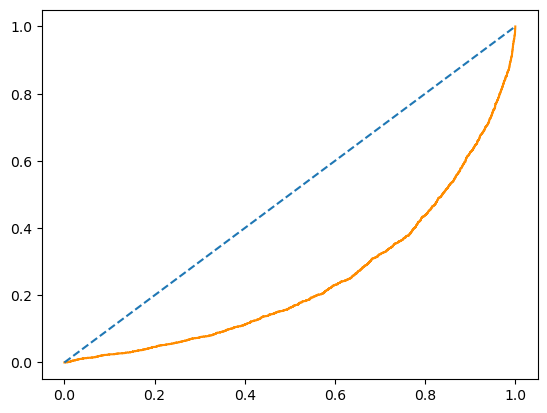

In [313]:
fallout, sensitivity, thresholds = roc_curve(np.ravel(crm.y_test), np.ravel(prob_default))
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
# auc = roc_auc_score(y_test, prob_default)

In [311]:
import matplotlib.pyplot as plt